In [1]:
import numpy as np
import matplotlib.pyplot as plt

project = 'newfault'
traindate = '2024-10-01'
testdate = '2024-10-02'
traindate_path = '/home/sdybing/gnss-picker/cnn_models_outputs/' + project + '_fq_train/models/traindate_' + traindate + '/'
test_outputs_path = traindate_path + 'data/'
figure_save_dir = traindate_path + 'figures/'
realdata_dir = '/home/sdybing/gnss-picker/data/realdata/summer23/'

realtest_data = np.load(test_outputs_path + testdate + '_realtest_orig_data.npy')
realtest_metadata = np.load(test_outputs_path + testdate + '_realtest_metadata.npy')
realtest_target = np.load(test_outputs_path + testdate + '_realtest_target.npy')
realtest_predictions = np.load(test_outputs_path + testdate + '_realtest_predictions.npy')
rows_w_eqs = np.load(realdata_dir + 'real_metadata_rembad_rows_w_eqs.npy')

num_realtest = len(realtest_predictions)
thresholds = np.arange(0, 1.005, 0.005)
test_thresholds = [0, 0.005]


In [2]:
print(realtest_data.shape)
print(realtest_metadata.shape)
print(realtest_target.shape)
print(realtest_predictions.shape)
print(rows_w_eqs.shape)

(994155, 128, 3)
(994155, 7)
(994155, 128)
(994155, 128)
(2123,)


In [3]:
# Metadata columns:
# 0: station name
# 1: date sample came from
# 2: sample start time
# 3: sample end time
# 4: random n counter
# 5: sample P-wave arrives at (gauss pos)
# 6: earthquake magnitude

In [4]:
##### -------------------- CLASSIFICATION TESTS -------------------- #####

# Decision threshold evaluation

thresholds = np.arange(0, 1.005, 0.005)
# thresholds = np.arange(0, 1.1, 0.1)
# thresholds = np.arange(0, 1, 0.1)
test_thresholds = [0.6]

# Use np.where to see whether anywhere in test_predictions is > threshold
# If there is a value that's >, the 'result' of the array is 1. If not 0
# Then compare these 1s and 0s to the target array value for PAR

accuracies = []
accuracies_per = []
precisions = []
recalls = []
F1s = []

TP_pert = []
TN_pert = []
FP_pert = []
FN_pert = []

for threshold in thresholds:
    
    print('-------------------------------------------------------------')
    print('Threshold: ' + str(threshold))
    print('-------------------------------------------------------------')
    
    # Convert the predictions arrays to single ones and zeroes
    
    pred_binary = np.zeros(len(realtest_predictions))
    iterate = np.arange(0,len(realtest_predictions),1)
    for k in iterate:
        # print('Prediction: ' + str(realtest_predictions[k]))
        i = np.where(realtest_predictions[k] >= threshold)[0]
        # print(i)
        if len(i) == 0:
            pred_binary[k] = 0
        elif len(i) > 0:
            pred_binary[k] = 1

#     print('Predictions: ')
#     print(pred_binary)
#     print(pred_binary.shape)
    
    # Convert the target arrays to single ones and zeroes
    
    targ_binary = np.zeros(len(realtest_target)) # Need to make this ones at indices in rows_w_eqs
    for idx in range(len(targ_binary)):
        if idx in rows_w_eqs:
            targ_binary[idx] = 1
    
#     print('Targets: ')
#     print(targ_binary)
    
    # Calculating the accuracy, precision, recall, and F1
    
    num_preds = len(realtest_predictions) # total number of predictions. Amanda did 50
    correct_preds = []
    wrong_preds = []
    true_pos = []
    true_neg = []
    false_pos = []
    false_neg = []
    
    for i in iterate:
        pred = pred_binary[i]
        targ = targ_binary[i]
        if pred == targ: # add one to list of correct predictions if matching
            correct_preds.append(1)
            if pred == 1 and targ == 1:
                true_pos.append(1)
            elif pred == 0 and targ == 0:
                true_neg.append(1)
        elif pred != targ: # add ones to list of incorrect predictions if not matching
            wrong_preds.append(1)
            if pred == 1 and targ == 0:
                false_pos.append(1)
            elif pred == 0 and targ == 1:
                false_neg.append(1)
    
    num_correct_preds = len(correct_preds)
    num_wrong_preds = len(wrong_preds)
    num_true_pos = len(true_pos)
    num_true_neg = len(true_neg)
    num_false_pos = len(false_pos)
    num_false_neg = len(false_neg)
    
    TP_pert.append(num_true_pos)
    TN_pert.append(num_true_neg)
    FP_pert.append(num_false_pos)
    FN_pert.append(num_false_neg)
    
#     print('Threshold: ' + str(threshold))
    print('Correct preds: ' + str(num_correct_preds))
    print('Wrong preds: ' + str(num_wrong_preds))
    print('True pos: ' + str(np.round(100*num_true_pos/num_preds,2)) + '%')
    print('True neg: ' + str(np.round(100*num_true_neg/num_preds,2)) + '%')
    print('False pos: ' + str(np.round(100*num_false_pos/num_preds,2)) + '%')
    print('False neg: ' + str(np.round(100*num_false_neg/num_preds,2)) + '%')
    
    accuracy = num_correct_preds / num_preds
    accuracy_per = (num_correct_preds / num_preds) * 100
    print('Accuracy: ' + str(np.round(accuracy_per,1)) + '%')
    
    if num_true_pos == 0  and num_false_pos == 0:
        precision = 0
    else:
        precision = num_true_pos / (num_true_pos + num_false_pos)
    
    if num_true_pos == 0 and num_false_neg == 0:
        recall = 0
    else:
        recall = num_true_pos / (num_true_pos + num_false_neg)
    
    if precision + recall == 0:
        F1 = 0
    else:
        F1 = 2 * ((precision * recall) / (precision + recall))
        
    accuracies.append(accuracy)
    accuracies_per.append(accuracy_per)
    precisions.append(precision)
    recalls.append(recall)
    F1s.append(F1)

-------------------------------------------------------------
Threshold: 0.0
-------------------------------------------------------------
Correct preds: 2123
Wrong preds: 992032
True pos: 0.21%
True neg: 0.0%
False pos: 99.79%
False neg: 0.0%
Accuracy: 0.2%
-------------------------------------------------------------
Threshold: 0.005
-------------------------------------------------------------
Correct preds: 2123
Wrong preds: 992032
True pos: 0.21%
True neg: 0.0%
False pos: 99.79%
False neg: 0.0%
Accuracy: 0.2%
-------------------------------------------------------------
Threshold: 0.01
-------------------------------------------------------------
Correct preds: 2123
Wrong preds: 992032
True pos: 0.21%
True neg: 0.0%
False pos: 99.79%
False neg: 0.0%
Accuracy: 0.2%
-------------------------------------------------------------
Threshold: 0.015
-------------------------------------------------------------
Correct preds: 2123
Wrong preds: 992032
True pos: 0.21%
True neg: 0.0%
False po

In [5]:
print(TP_pert)

[2123, 2123, 2123, 2123, 2123, 2123, 2103, 1793, 1158, 700, 447, 347, 280, 233, 212, 186, 172, 158, 149, 131, 121, 115, 110, 107, 105, 102, 98, 93, 90, 86, 79, 77, 77, 75, 74, 71, 69, 68, 66, 64, 60, 59, 58, 55, 53, 51, 50, 50, 49, 49, 49, 48, 48, 48, 48, 48, 48, 48, 48, 48, 47, 47, 47, 47, 47, 47, 46, 45, 45, 45, 45, 45, 45, 44, 44, 44, 43, 43, 42, 41, 40, 39, 39, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 36, 36, 36, 36, 36, 36, 36, 35, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 32, 32, 32, 32, 32, 31, 31, 31, 31, 31, 31, 31, 31, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 29, 29, 29, 28, 28, 28, 27, 27, 27, 27, 26, 26, 25, 25, 24, 24, 23, 22, 21, 20, 20, 20, 20, 19, 17, 16, 15, 15, 14, 12, 10, 9, 7, 7, 6, 6, 5, 2, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [10]:
np.save(test_outputs_path + 'real_testing/classification_stats/thresholds.npy', thresholds)
np.save(test_outputs_path + 'real_testing/classification_stats/accuracies.npy', accuracies)
np.save(test_outputs_path + 'real_testing/classification_stats/precisions.npy', precisions)
np.save(test_outputs_path + 'real_testing/classification_stats/recalls.npy', recalls)
np.save(test_outputs_path + 'real_testing/classification_stats/F1s.npy', F1s)

In [11]:
np.save(test_outputs_path + 'real_testing/classification_stats/TNnum.npy', TN_pert)
np.save(test_outputs_path + 'real_testing/classification_stats/FPnum.npy', FP_pert)
np.save(test_outputs_path + 'real_testing/classification_stats/TPnum.npy', TP_pert)
np.save(test_outputs_path + 'real_testing/classification_stats/FNnum.npy', FN_pert)

# np.savetxt(test_outputs_path + 'realtestdata_rembad_accuracies_percentage_txt.txt', accuracies_per)
# np.savetxt(test_outputs_path + 'realtestdata_rembad_thresholds_txt.txt', thresholds)

In [12]:
# Find threshold with highest accuracy

acc0 = 0

for idx in range(len(accuracies_per)):
    acc = accuracies_per[idx]
    if acc > acc0:
        acc0 = acc
        best_thresh = thresholds[idx] # Only updates when it hits a higher accuracy
        
print(best_thresh)

0.905


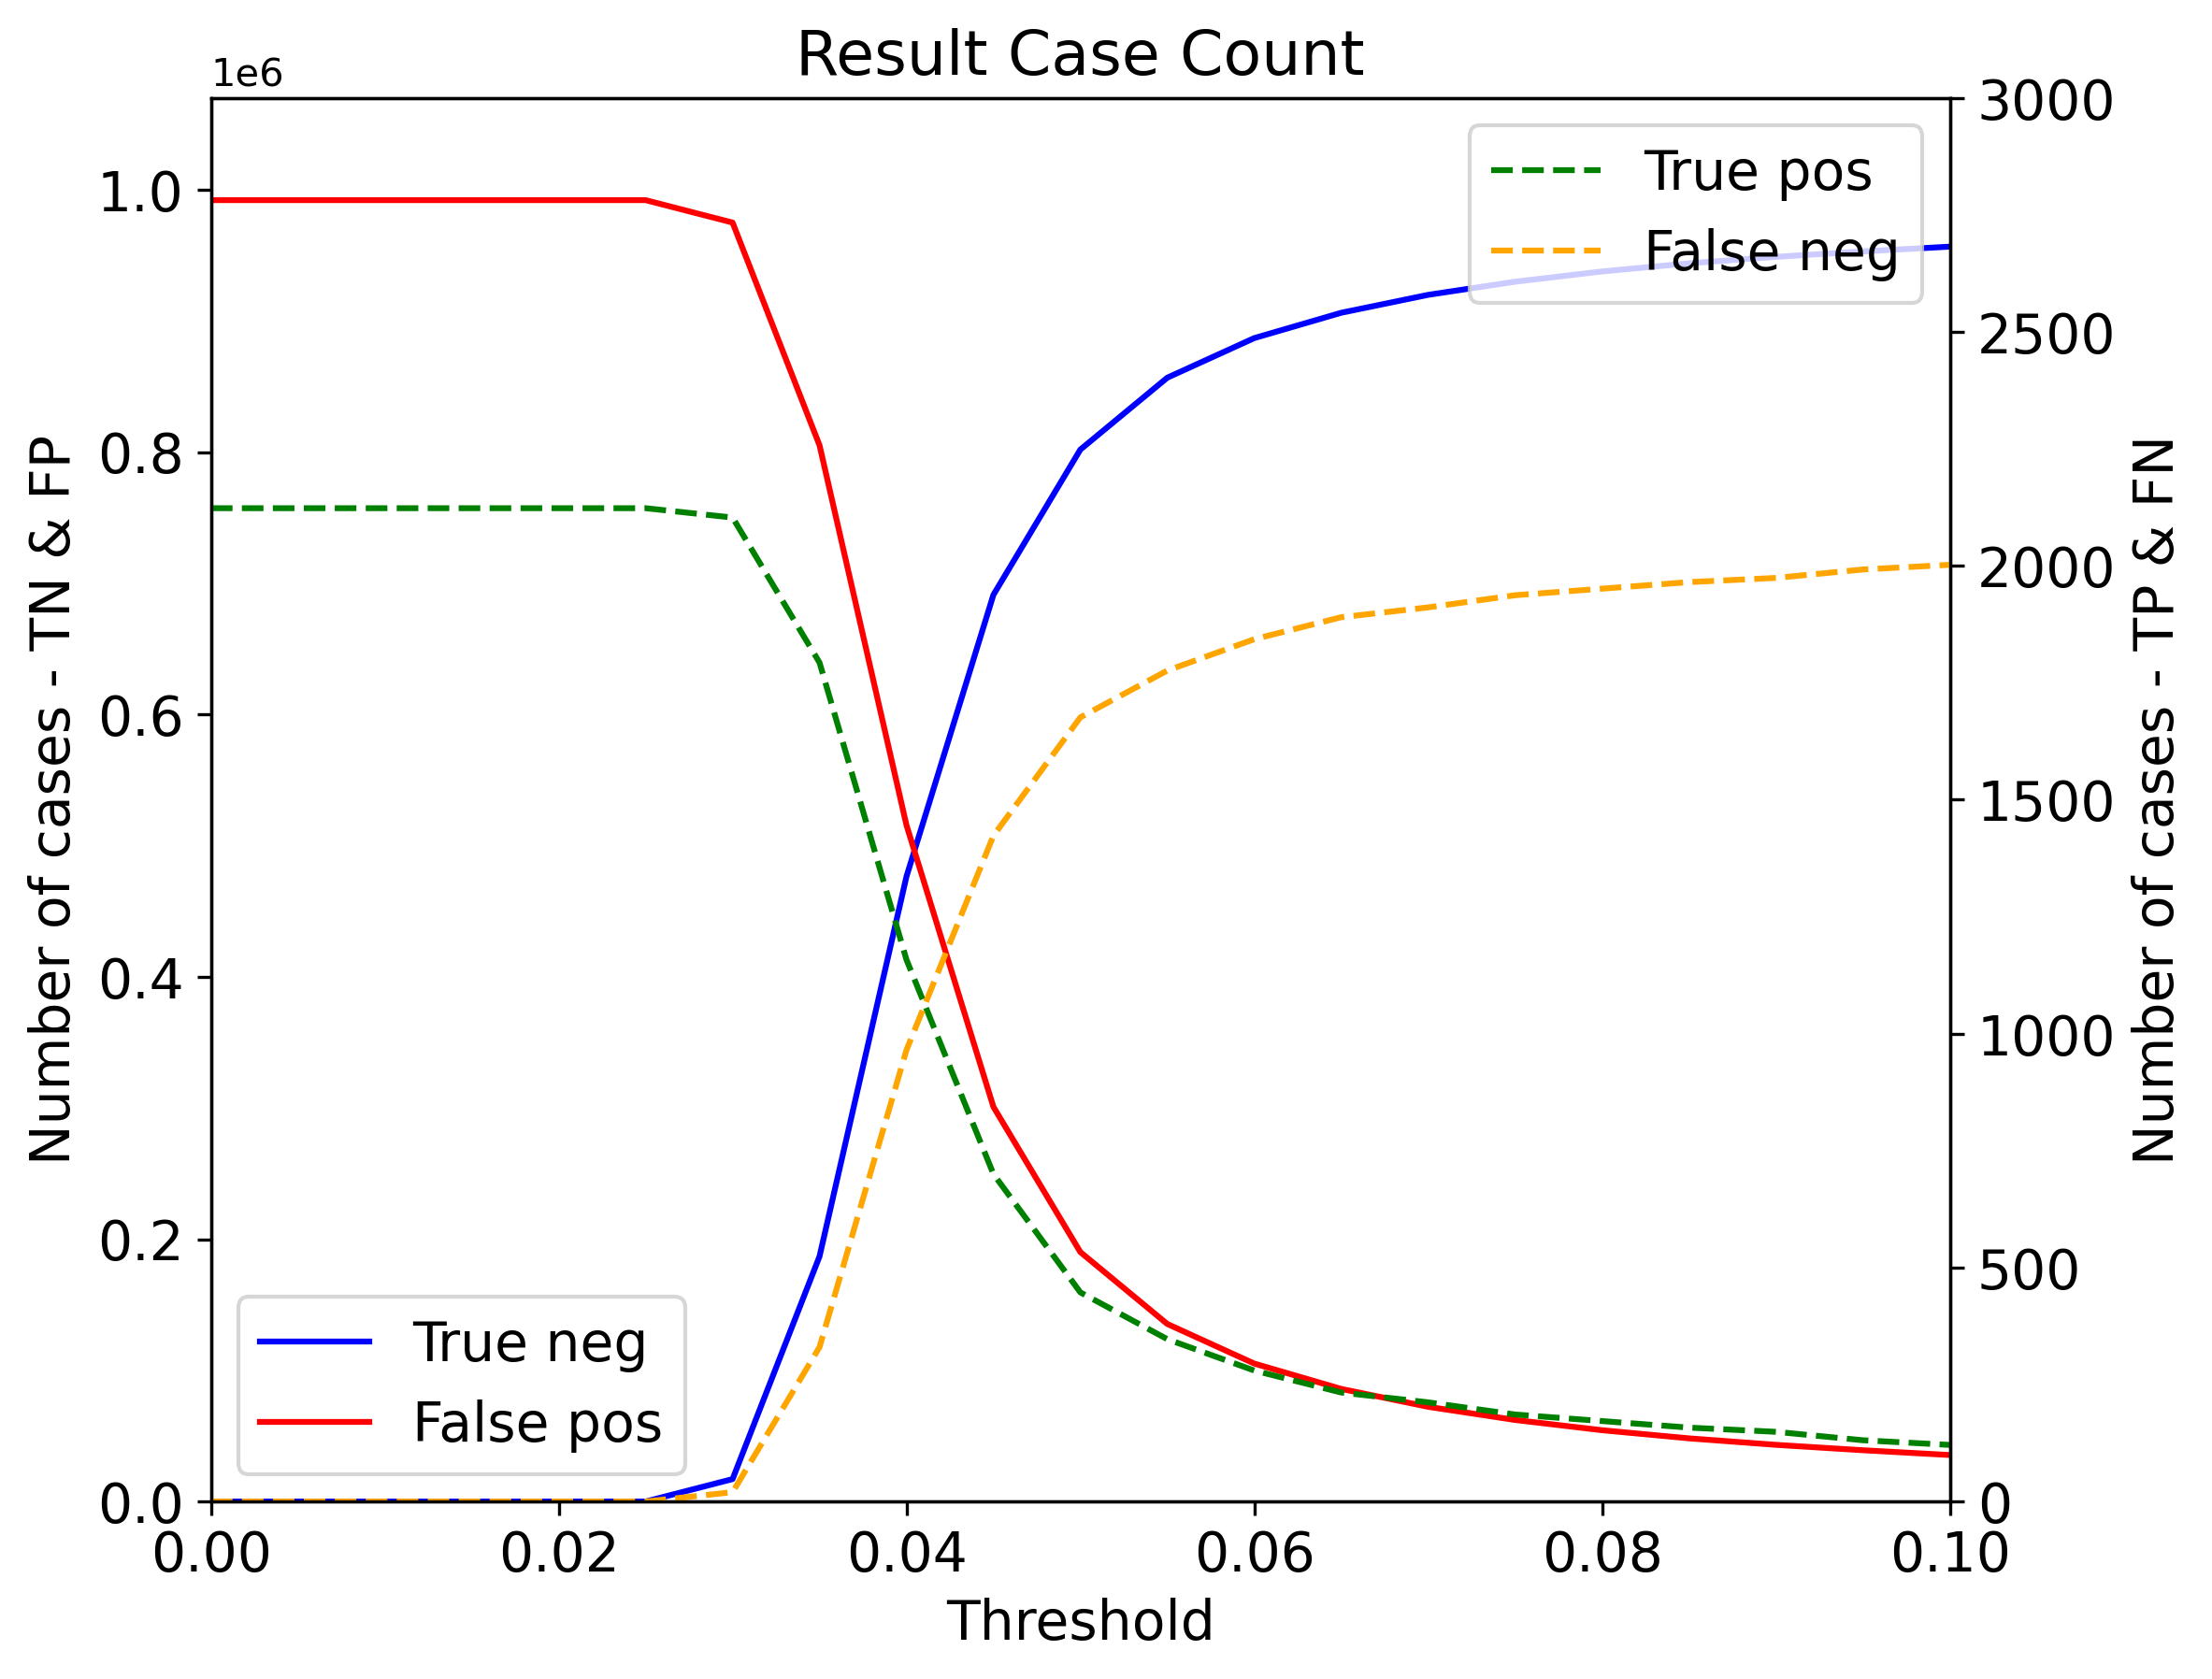

In [13]:
plt.figure(figsize = (8,6.5), dpi = 300)
ax1 = plt.subplot(111)

ax1.plot(thresholds, np.array(TN_pert), label = 'True neg', color = 'blue')
ax1.plot(thresholds, np.array(FP_pert), label = 'False pos', color = 'red')
ax1.set_xlim(0,0.1)
ax2 = ax1.twinx()
ax2.plot(thresholds, np.array(TP_pert), label = 'True pos', color = 'green', linestyle = 'dashed')
ax2.plot(thresholds, np.array(FN_pert), label = 'False neg', color = 'orange', linestyle = 'dashed')
ax2.set_ylim(0,3000)
ax1.set_ylim(0,1070000)
ax1.set_xlabel('Threshold', fontsize = 14)
ax1.set_ylabel('Number of cases - TN & FP', fontsize = 14)
ax2.set_ylabel('Number of cases - TP & FN', fontsize = 14)
ax1.tick_params(labelsize = 14)
ax2.tick_params(labelsize = 14)
ax1.legend(fontsize = 14)
ax2.legend(fontsize = 14)
plt.title('Result Case Count', fontsize = 16)
plt.show();
# plt.savefig(figure_save_dir + '17b_realtestdata_outcomecurves_cropped.png', format = 'PNG', facecolor = 'white')
# plt.close();


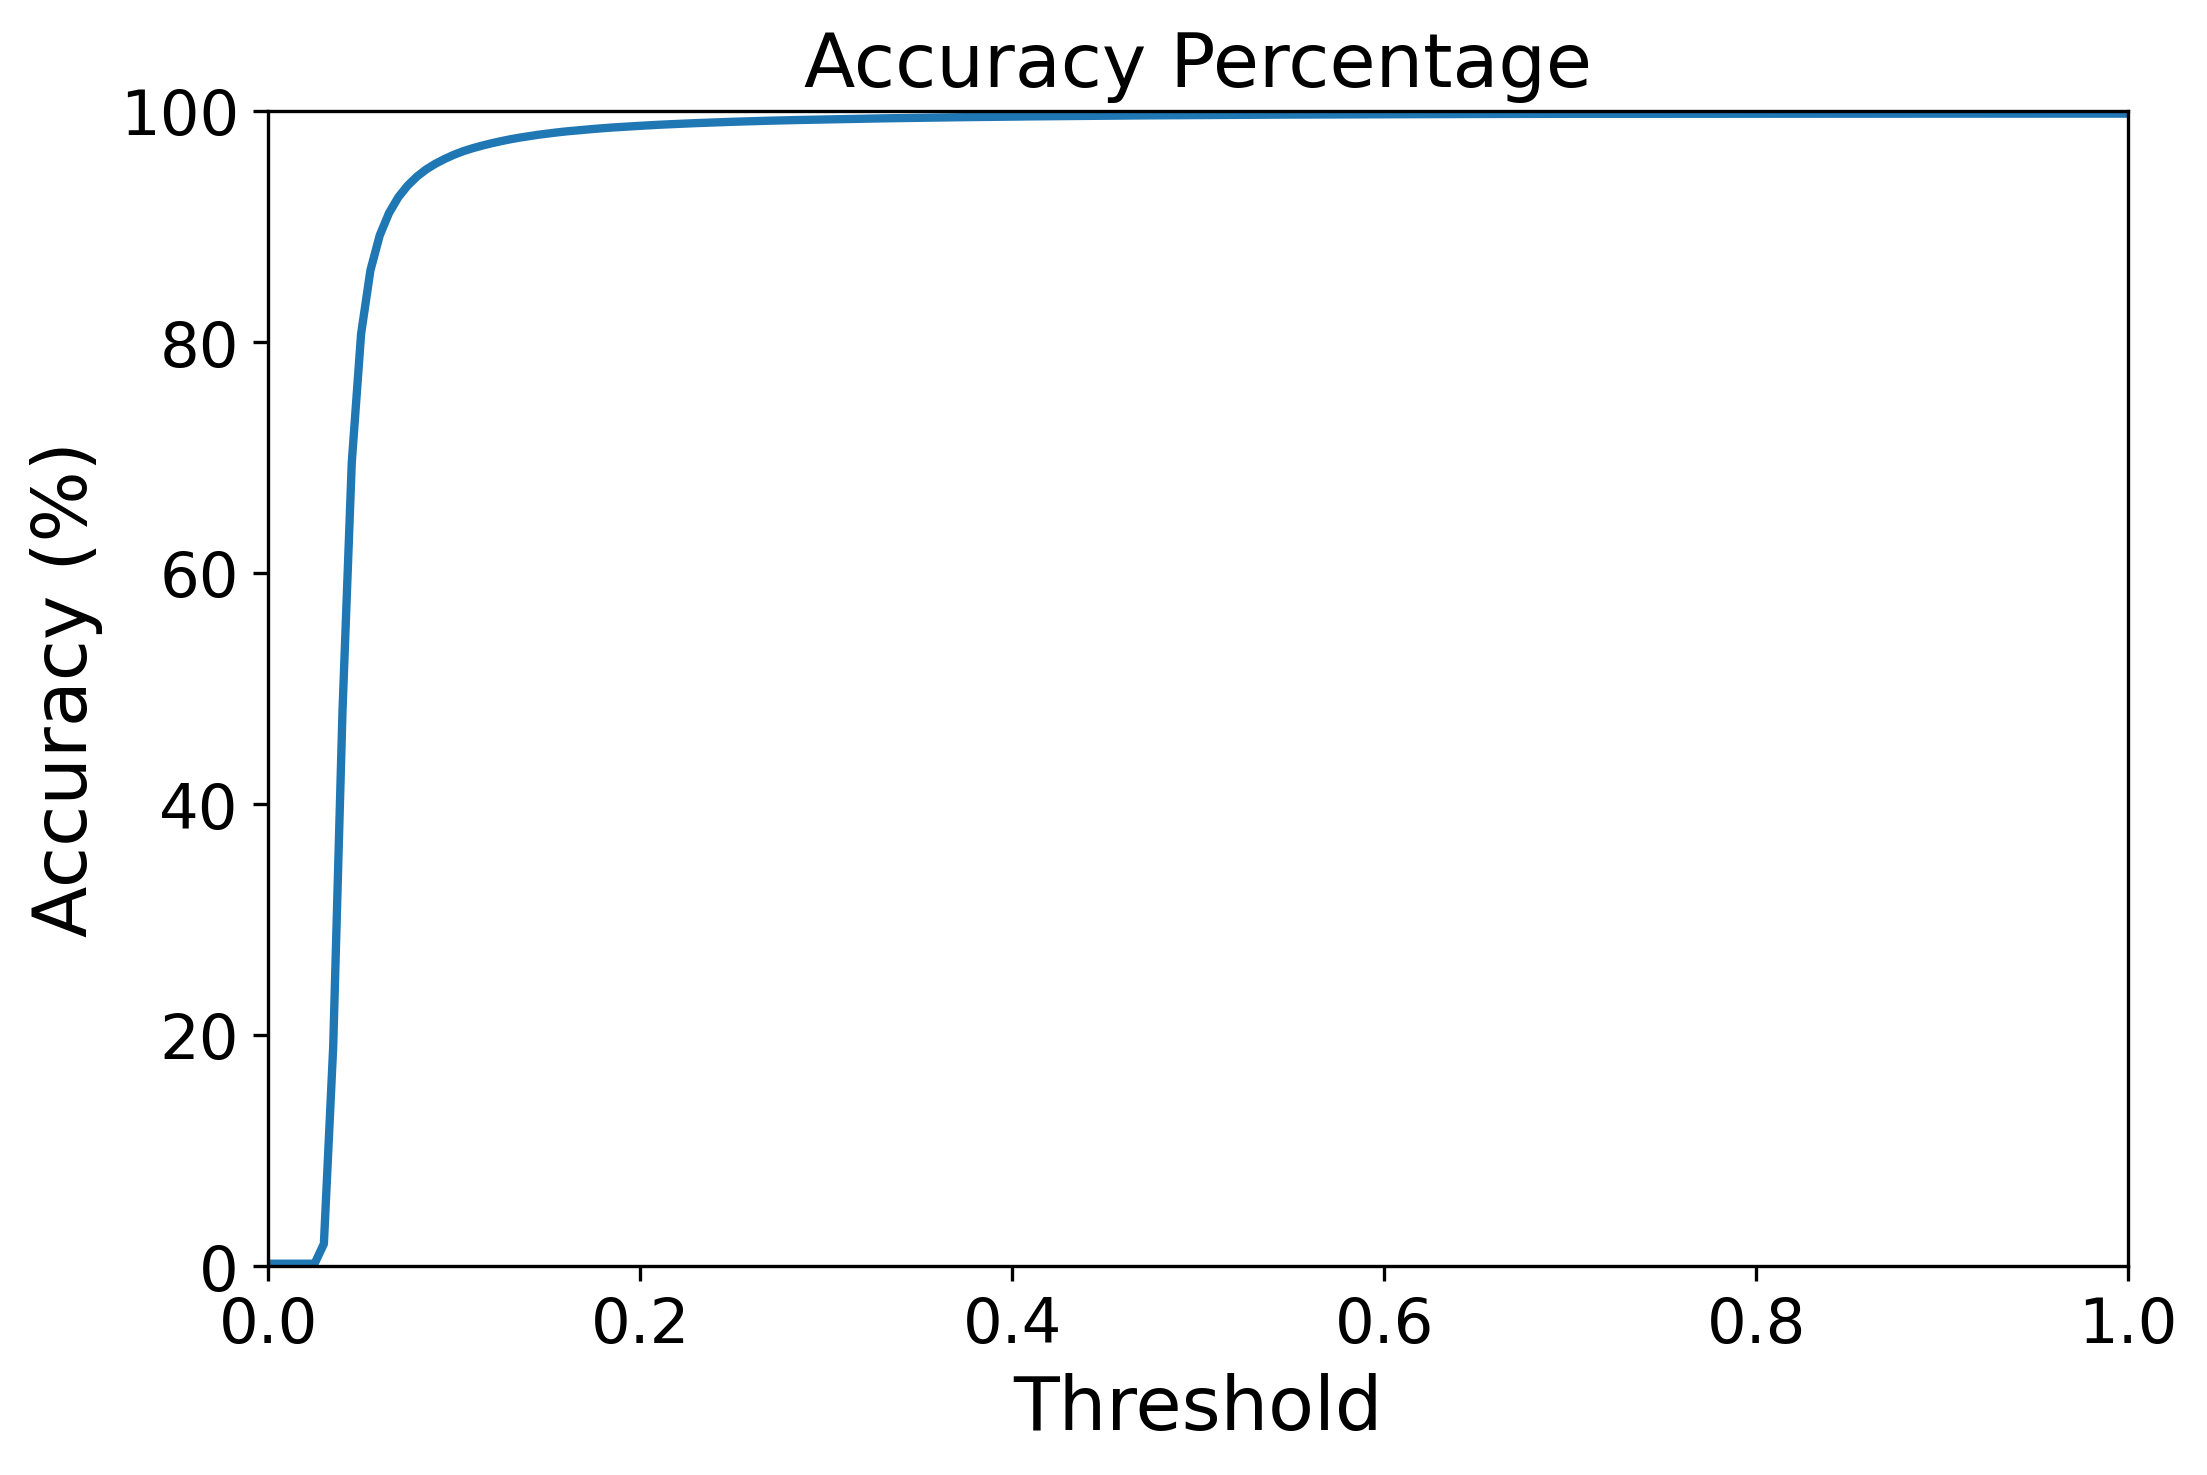

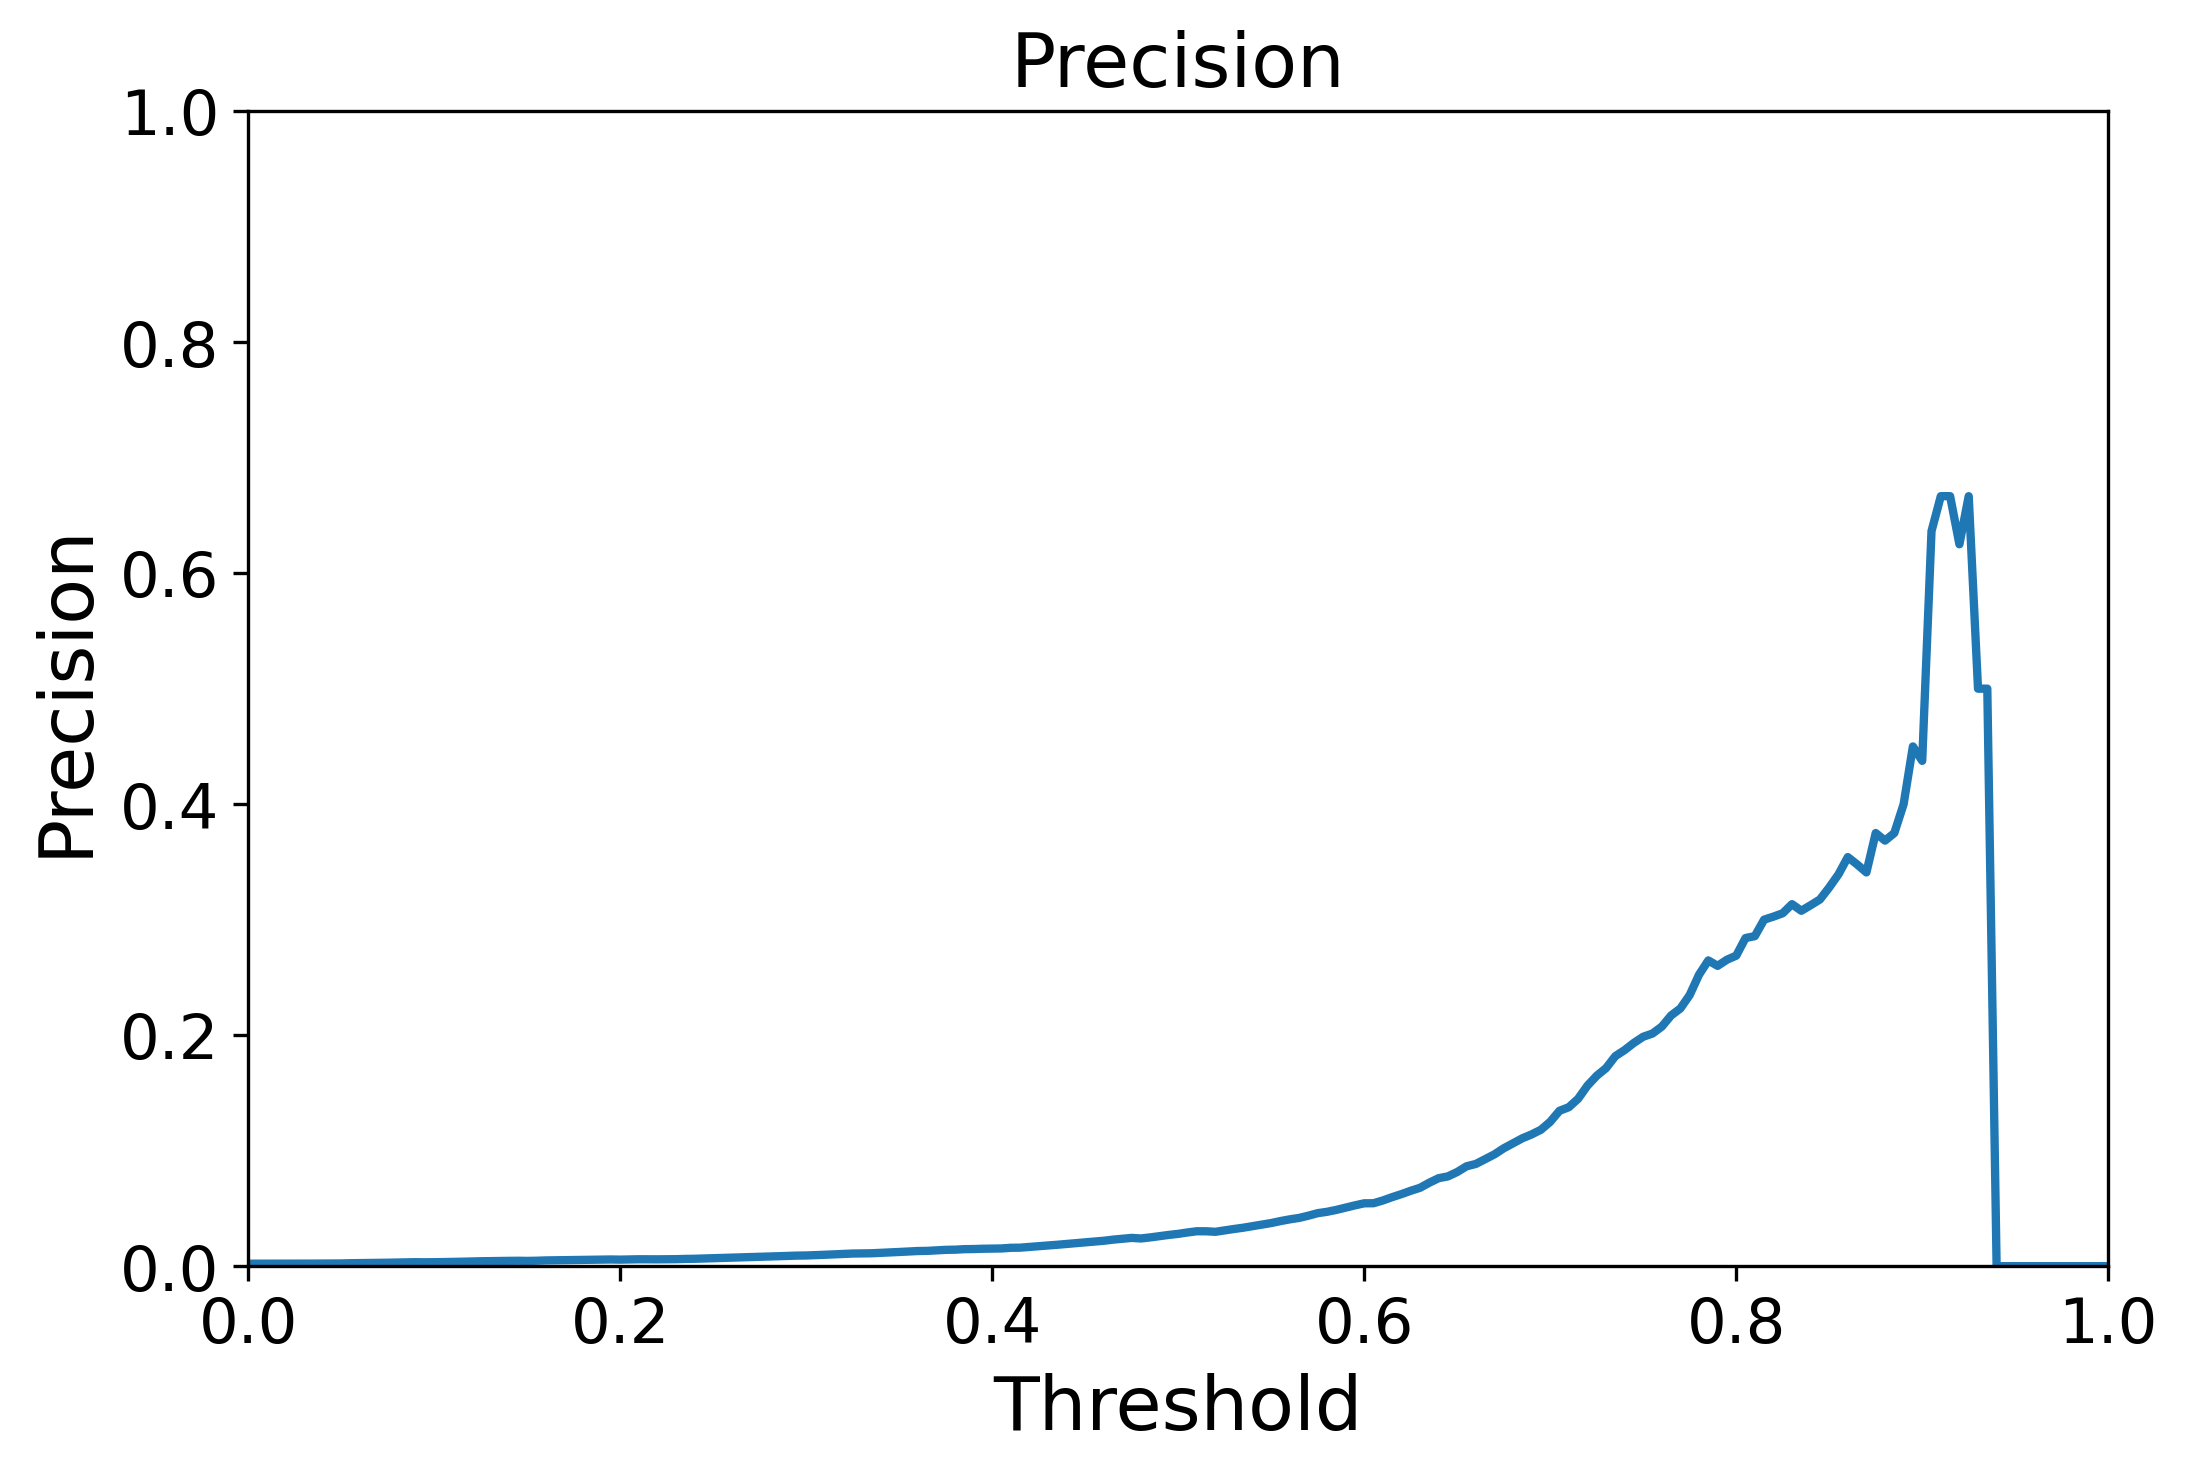

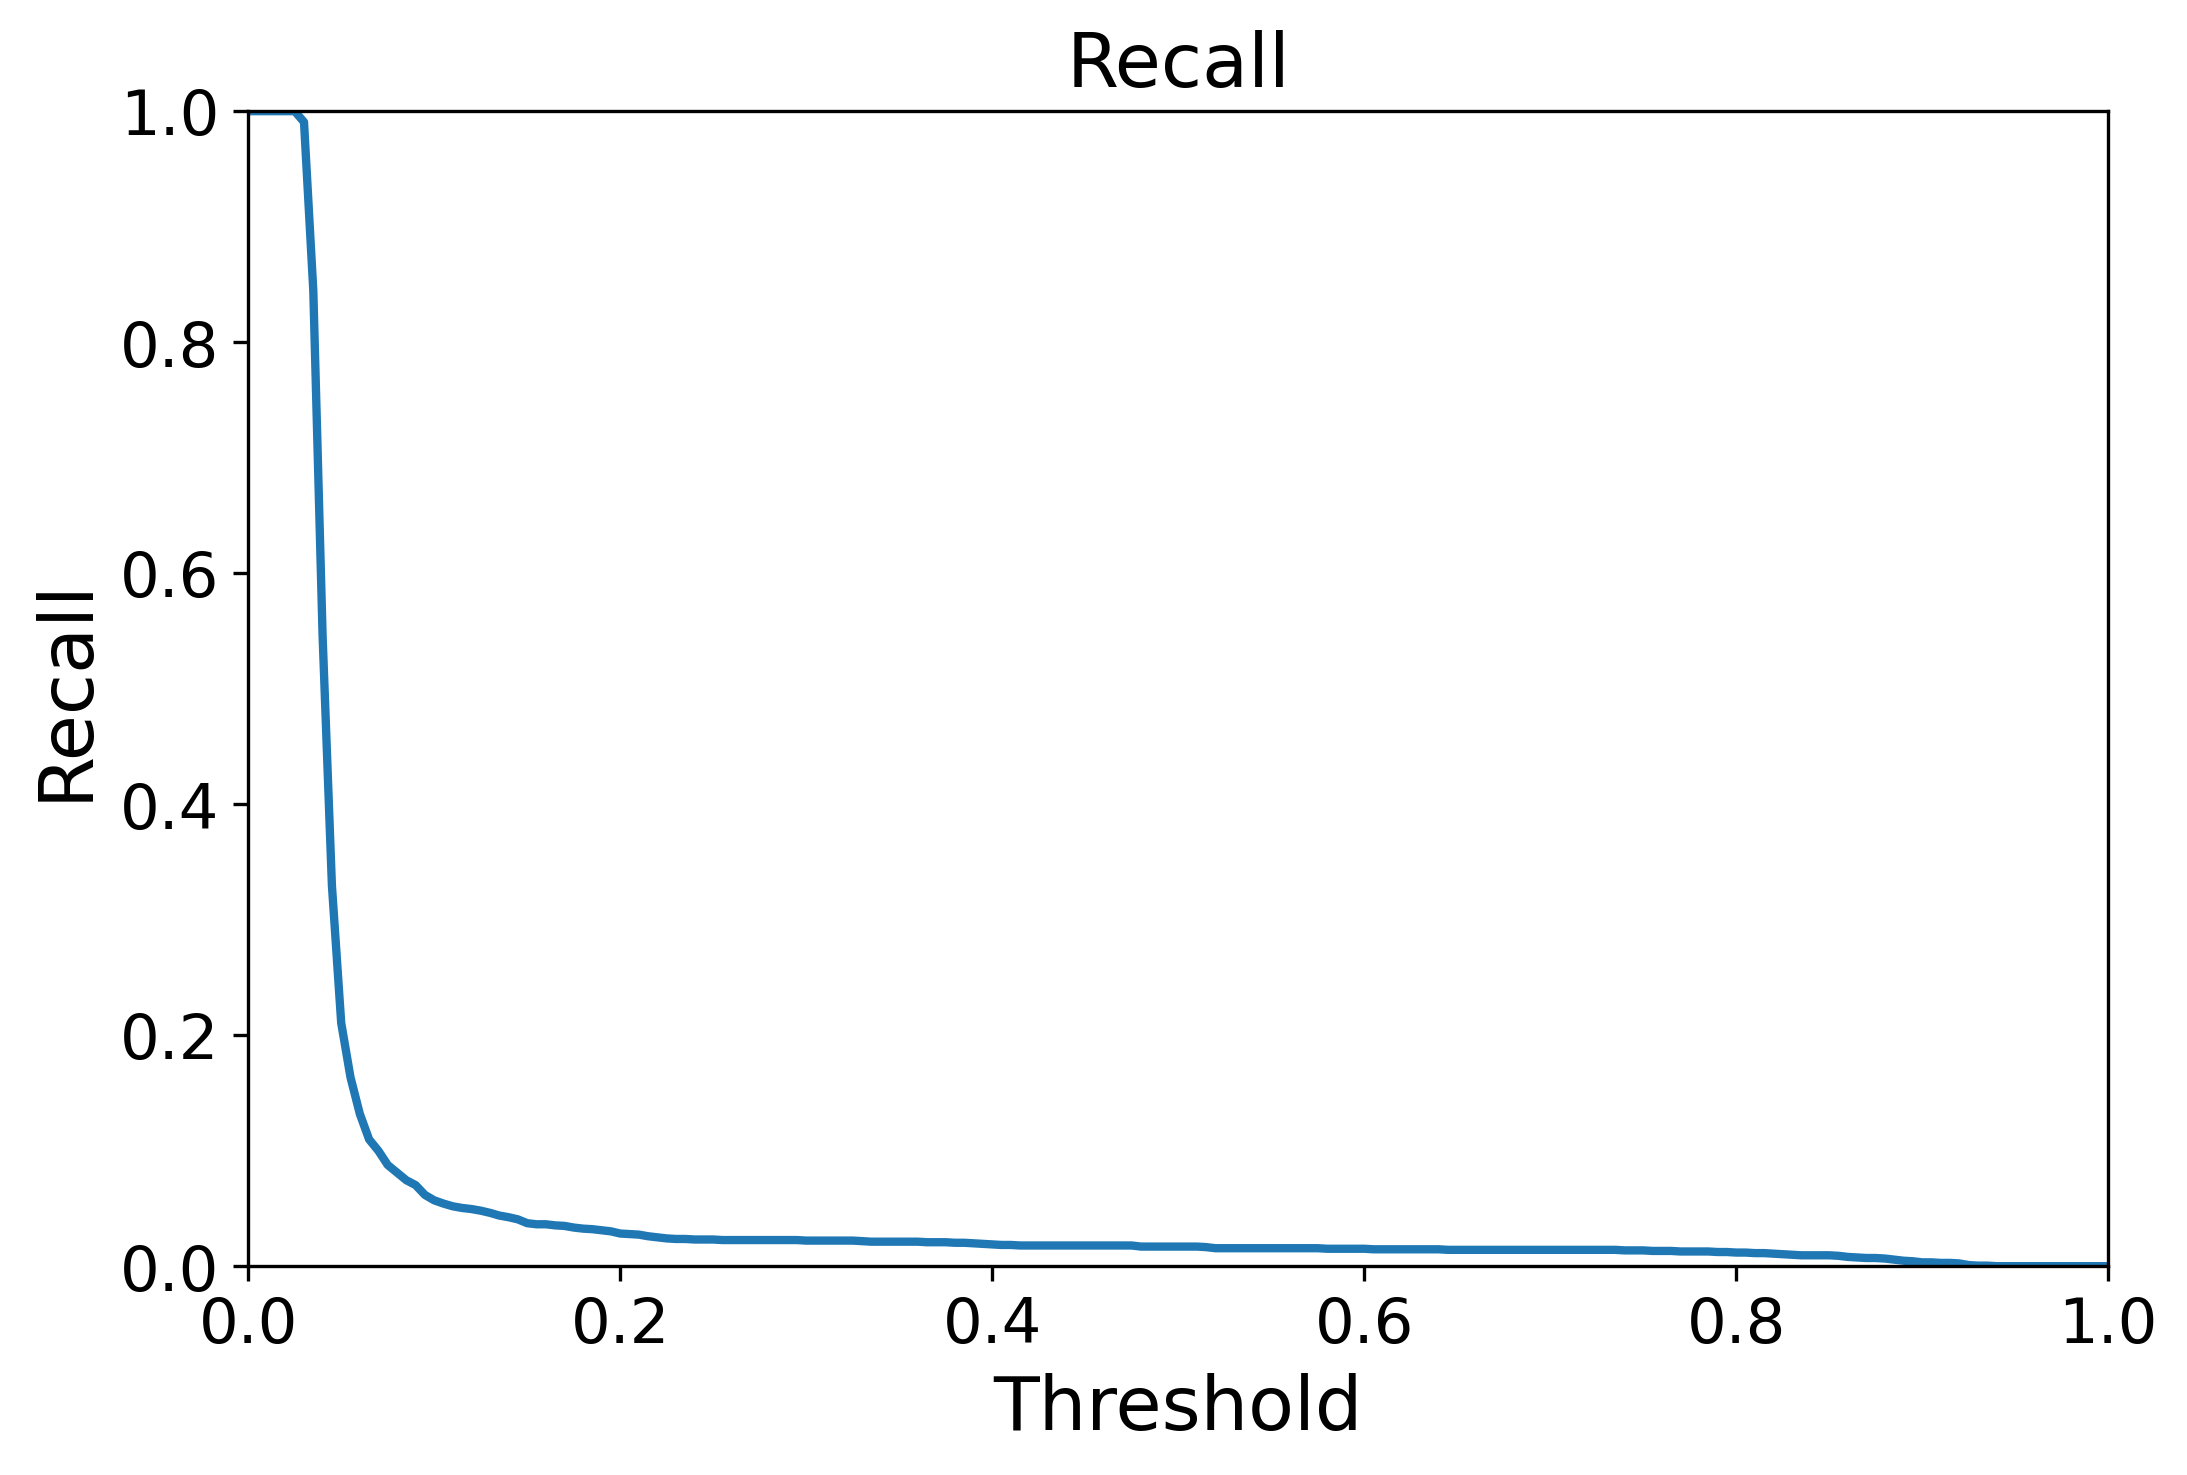

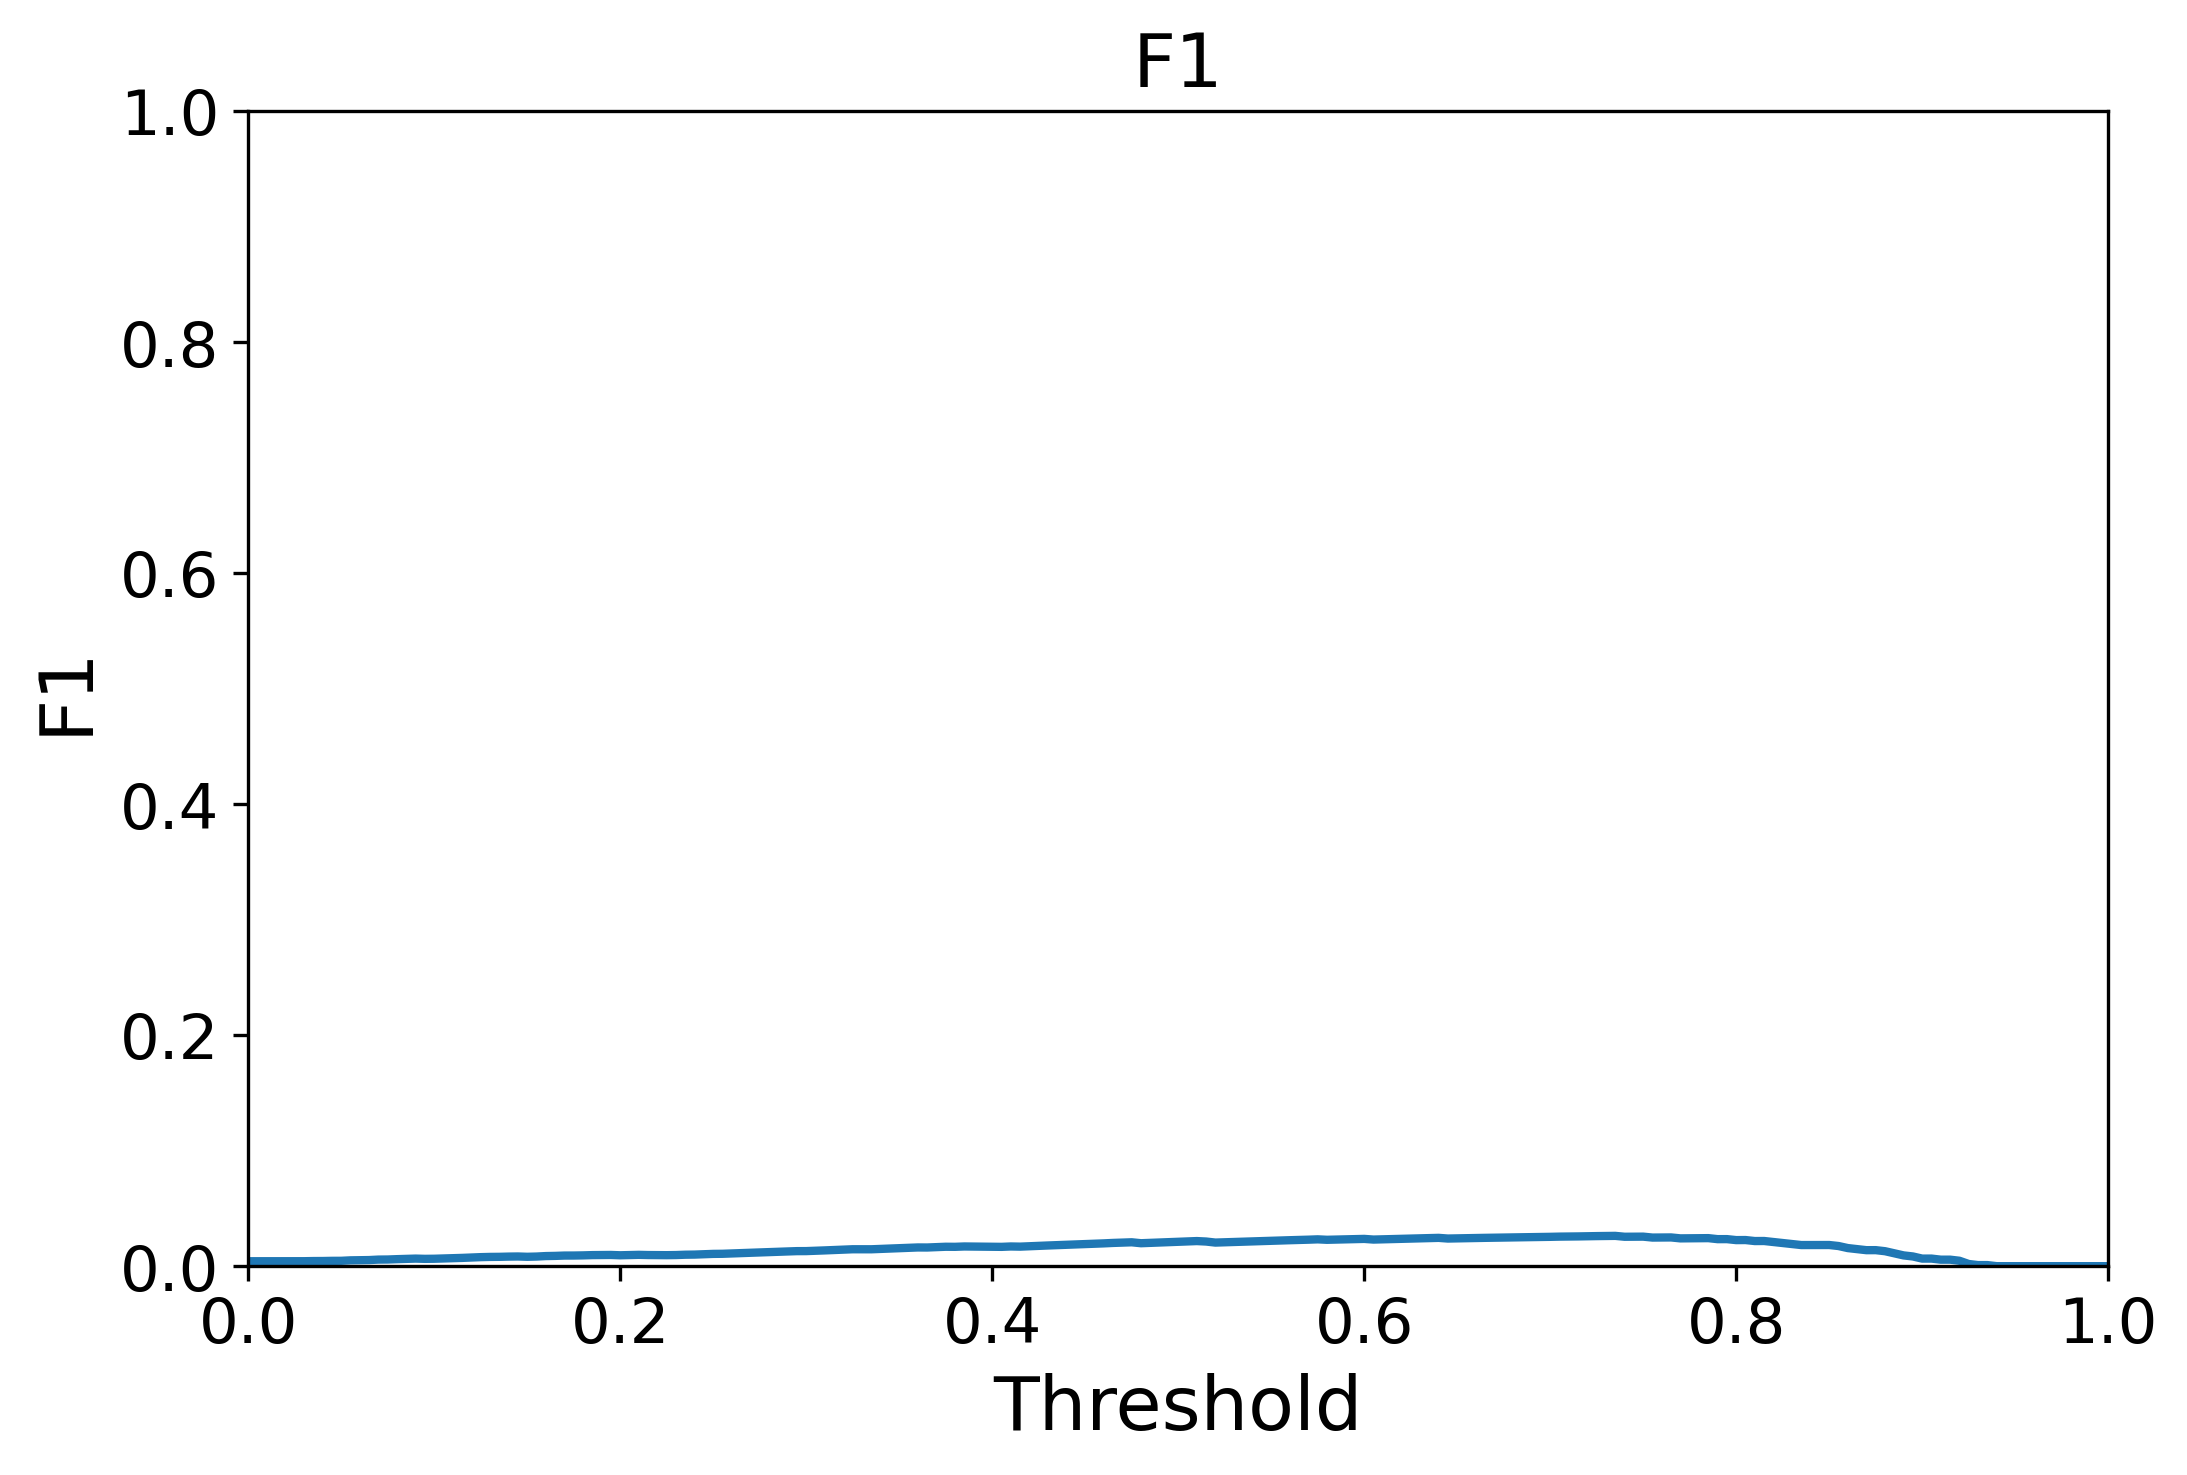

In [14]:
plt.figure(figsize = (8,5), dpi = 300)
#plt.figure(figsize = (8,5))
# plt.scatter(thresholds,accuracies)
plt.plot(thresholds, accuracies_per, linewidth = 2)
plt.xlabel('Threshold', fontsize = 18)
plt.ylabel('Accuracy (%)', fontsize = 18)
plt.xlim(0,1)
plt.ylim(0,100)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.title('Accuracy Percentage', fontsize = 18)
plt.show();
# plt.savefig(figure_save_dir + '18a_realtestdata_accuracies_by_threshold.png', format = 'PNG', facecolor = 'white')
# plt.close();

plt.figure(figsize = (8,5), dpi = 300)
#plt.figure(figsize = (8,5))
plt.plot(thresholds, precisions, linewidth = 2)
plt.xlabel('Threshold', fontsize = 18)
plt.ylabel('Precision', fontsize = 18)
plt.xlim(0,1)
plt.ylim(0,1)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.title('Precision', fontsize = 18)
plt.show();
# plt.savefig(figure_save_dir + '18b_realtestdata_precisions_by_threshold.png', format = 'PNG', facecolor = 'white')
# plt.close();

plt.figure(figsize = (8,5), dpi = 300)
#plt.figure(figsize = (8,5))
plt.plot(thresholds, recalls, linewidth = 2)
plt.xlabel('Threshold', fontsize = 18)
plt.ylabel('Recall', fontsize = 18)
plt.xlim(0,1)
plt.ylim(0,1)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.title('Recall', fontsize = 18)
plt.show();
# plt.savefig(figure_save_dir + '18c_realtestdata_recalls_by_threshold.png', format = 'PNG', facecolor = 'white')
# plt.close()

plt.figure(figsize = (8,5), dpi = 300)
#plt.figure(figsize = (8,5))
plt.plot(thresholds, F1s, linewidth = 2)
plt.xlabel('Threshold', fontsize = 18)
plt.ylabel('F1', fontsize = 18)
plt.xlim(0,1)
plt.ylim(0,1)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.title('F1', fontsize = 18)
plt.show();
# plt.savefig(figure_save_dir + '18d_realtestdata_F1s_by_threshold.png', format = 'PNG', facecolor = 'white')
# plt.close();


In [ ]:
# Subplot version

In [16]:
plt.figure(figsize = (8,5), dpi = 400)

plt.subplot(221)
plt.text(x = -0.3, y = 0.9, s = '(a)', fontsize = 22)
plt.grid(lw = 0.5, zorder = 0)
plt.plot(thresholds, accuracies, linewidth = 2)
plt.ylabel('Accuracy', fontsize = 12)
plt.xlim(0,1)
plt.ylim(0,1)
plt.axvline(best_thresh, color = 'red', linestyle = '--', alpha = 0.6, label = 'Max accuracy at threshold of ' + str(best_thresh))
plt.tick_params(axis = 'both', bottom = False, labelbottom = False)
plt.yticks(fontsize = 11)
plt.legend(loc = (0.55,-1.45))

# plt.legend()

plt.subplot(222)
plt.text(x = -0.3, y = 0.9, s = '(b)', fontsize = 22)
plt.grid(lw = 0.5, zorder = 0)
plt.plot(thresholds, precisions, linewidth = 2)
plt.ylabel('Precision', fontsize = 12)
plt.xlim(0,1)
plt.ylim(0,1)
plt.tick_params(axis = 'both', bottom = False, labelbottom = False)
plt.axvline(best_thresh, color = 'red', linestyle = '--', alpha = 0.6)
plt.yticks(fontsize = 11)


plt.subplot(223)
plt.text(x = -0.3, y = 0.9, s = '(c)', fontsize = 22)
plt.grid(lw = 0.5, zorder = 0)
plt.plot(thresholds, recalls, linewidth = 2)
plt.xlabel('Threshold', fontsize = 12)
plt.ylabel('Recall', fontsize = 12)
plt.xlim(0,1)
plt.ylim(0,1)
plt.xticks(fontsize = 11)
plt.yticks([0, 0.2, 0.4, 0.6, 0.8], fontsize = 11)
plt.axvline(best_thresh, color = 'red', linestyle = '--', alpha = 0.6)

plt.subplot(224)
plt.text(x = -0.3, y = 0.9, s = '(d)', fontsize = 22)
plt.grid(lw = 0.5, zorder = 0)
plt.plot(thresholds, F1s, linewidth = 2)
plt.xlabel('Threshold', fontsize = 12)
plt.ylabel('F1', fontsize = 12)
plt.xlim(0,1)
plt.ylim(0,1)
plt.xticks(fontsize = 11)
plt.yticks([0, 0.2, 0.4, 0.6, 0.8], fontsize = 11)
plt.axvline(best_thresh, color = 'red', linestyle = '--', alpha = 0.6)

plt.subplots_adjust(hspace = 0, wspace = 0.32, bottom = 0.2)

# plt.show()

plt.savefig('/home/sdybing/gnss-picker/manuscript_figures/real_testdata_classification.jpg', format = 'JPG')
plt.close();